In [17]:
#Imports
import os
import pickle
import random
import numpy as np
import shutil
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from argparse import Namespace
import torch.nn as nn
import torch
from torch import linalg as LA
import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

logger = logging.getLogger(__name__)
#wandb_logger = lambda dir, version: WandbLogger(
 #   name="wandb", save_dir=dir, version=version
#)
def wandb_logger(dir,version,name):
    return WandbLogger(
    name=name, save_dir=dir, version=version
)
csvlogger = lambda dir, version: CSVLogger(dir, name="csvlogs", version=version)
tblogger = lambda dir, version: TensorBoardLogger(dir, name="tblogs", version=version)

def get_loggers(dir,version,name,lis=["csv"]):
    lgrs = []
    if "wandb" in lis:
        lgrs.append(wandb_logger(dir, version))
    if "csv" in lis:
        lgrs.append(csvlogger(dir, version))
    if "tb" in lis:
        lgrs.append(tblogger(dir, version))
    return lgrs

#global vars
DATA_DIR = '/common/home/vk405/Projects/Crossmdl/Data/Recipe/'
EMB_TRN = DATA_DIR+'embeddings_train1.pkl'
EMB_VAL = DATA_DIR+'embeddings_val1.pkl'
ING_TRN = DATA_DIR+'ingredients_embeddings_train.pkl'
ING_VAL = DATA_DIR+'ingredients_embeddings_val.pkl'
#os.listdir(DATA_DIR)

In [12]:



with open(ING_TRN, 'rb') as files:
    ing_trn = pickle.load(files)
with open(ING_VAL, 'rb') as files:
    ing_val = pickle.load(files)



In [14]:
len(ing_trn)

2

In [17]:
ing_trn[0].shape

(281598, 1024)

In [18]:
class RecipeDset(Dataset):
    def __init__(self,data_dir= '/common/home/vk405/Projects/Crossmdl/Data/Recipe/'\
        ,split='train',txt_emb_type='total'):
        self.DATA_DIR = data_dir
        self.init_data_locs()
        self.txt_emb_type = txt_emb_type
        self.split = split
        
        if self.split == 'train':
            with open(self.EMB_TRN, 'rb') as files:
                self.emb_vid,_,_ = pickle.load(files)
            if self.txt_emb_type == 'total':
                with open(self.EMB_TRN, 'rb') as files:
                    self.emb_vid,self.emb_txt,self.ids = pickle.load(files)
            elif self.txt_emb_type == 'instructions':
                with open(self.INS_TRN, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)
            elif self.txt_emb_type == 'ingredients':
                with open(self.ING_TRN, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)
            else:
                #title
                with open(self.TIT_TRN, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)


            
        elif self.split == 'valid':
            with open(self.EMB_VAL, 'rb') as files:
                    self.emb_vid,_,_ = pickle.load(files)
            if self.txt_emb_type == 'total':
                with open(self.EMB_VAL, 'rb') as files:
                    self.emb_vid,self.emb_txt,self.ids = pickle.load(files)
            elif self.txt_emb_type == 'instructions':
                with open(self.INS_VAL, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)
            elif self.txt_emb_type == 'ingredients':
                with open(self.ING_VAL, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)
            else:
                #title
                with open(self.TIT_VAL, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)

        elif self.split == 'test':
            with open(self.EMB_TST, 'rb') as files:
                self.emb_vid,_,_ = pickle.load(files)

            if self.txt_emb_type == 'total':
                with open(self.EMB_TST, 'rb') as files:
                    self.emb_vid,self.emb_txt,self.ids = pickle.load(files)
            elif self.txt_emb_type == 'instructions':
                with open(self.INS_TST, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)
            elif self.txt_emb_type == 'ingredients':
                with open(self.ING_TST, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)
            else:
                #title
                with open(self.TIT_TST, 'rb') as files:
                    self.emb_txt,self.ids = pickle.load(files)


    def __getitem__(self,idx):
        rind = idx+1
        if rind == len(self.emb_txt):
            rind = idx-1
        return self.emb_vid[idx],self.emb_txt[idx],self.emb_vid[rind]

    def __len__(self):
        return len(self.emb_txt)

    def init_data_locs(self):
        #TOTAL EMBEDDINGS
        self.EMB_TRN = self.DATA_DIR+'embeddings_train1.pkl'
        self.EMB_VAL = self.DATA_DIR+'embeddings_val1.pkl'
        self.EMB_TST = self.DATA_DIR+'embeddings_test1.pkl'
        #INGRIDIENTS Embeddings
        self.ING_TRN = self.DATA_DIR+'ingredients_embeddings_train.pkl'
        self.ING_VAL = self.DATA_DIR+'ingredients_embeddings_val.pkl'
        self.ING_TST = self.DATA_DIR + 'ingredients_embeddings_test.pkl'

        #TITLE EMBEDDINGS
        self.TIT_TRN = self.DATA_DIR+'title_embeddings_train.pkl'
        self.TIT_VAL = self.DATA_DIR+'title_embeddings_val.pkl'
        self.TIT_TST = self.DATA_DIR + 'title_embeddings_test.pkl'

        #Instructions
        self.INS_TRN = self.DATA_DIR+'instructions_embeddings_train.pkl'
        self.INS_VAL = self.DATA_DIR+'instructions_embeddings_val.pkl'
        self.INS_TST = self.DATA_DIR+'instructions_embeddings_test.pkl'


        

In [5]:
#trn_data = RecipeDset()


In [19]:
class EmbModel(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.params = params
        self.lyrs = []
        dim = self.params['input_dim']
        for i in range(self.params['lyrs']):
            if "emb_dim" not in self.params:
                lyr = nn.Linear(dim,dim)
            else:
                prev_dim = dim
                out_dim = self.params['emb_dim'][i]
                if i>0:
                    prev_dim = self.params['emb_dim'][i-1]
                lyr = nn.Linear(prev_dim,out_dim)
            if self.params['act'] == 'relu':
                non_lin = nn.ReLU()
            else:
                raise NotImplementedError
            self.lyrs.append(lyr)
            self.lyrs.append(non_lin)
        self.feedforward = nn.Sequential(*self.lyrs)
    def forward(self,x):
        return self.feedforward(x)





class RecipeModel(pl.LightningModule):
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        self.txt_emb = EmbModel(hparams.txt_model)
        self.img_emb = EmbModel(hparams.img_model)
        self.shared = nn.Linear(hparams.txt_model['fin_dim'],\
            hparams.shared_emb_dim)
    def forward(self,x):
        # Ignores anchor embedding
        img,txt = x
        img_emb = self.img_emb(img)
        txt_emb = self.txt_emb(txt)
        #anch_img_emb = self.img_emb(anch_img)

        img_fin_emb = self.shared(img_emb)
        txt_fin_emb = self.shared(txt_emb)
        #anch_img_fin_emb = self.shared(anch_img_emb)
        return img_fin_emb,txt_fin_emb

    def training_step(self,batch,batch_idx):
        img,txt,anch_img = batch
        anch_img_emb = self.img_emb(anch_img)
        anch_img_fin_emb = self.shared(anch_img_emb)
        img_fin_emb,txt_fin_emb = self((img,txt))

        loss,log_losses = self.get_loss(img_fin_emb,txt_fin_emb,anch_img_fin_emb)
        self.log("train_loss",loss,on_step=True)
        self.log("cos_sim_n",log_losses[0],on_step=True)
        self.log("cos_sim_p",log_losses[-1],on_step=True)

        return loss

    def validation_step(self,batch,batch_idx):
        img,txt,anch_img = batch
        anch_img_emb = self.img_emb(anch_img)
        anch_img_fin_emb = self.shared(anch_img_emb)
        img_fin_emb,txt_fin_emb = self((img,txt))
        loss,log_losses = self.get_loss(img_fin_emb,txt_fin_emb,anch_img_fin_emb)
        #collects batchwise stats for rank over half of batchsize
        sz = int(img_fin_emb.shape[0]//2)
        median,recall = self.rank('image',img_fin_emb.detach().cpu().numpy(),txt_fin_emb.detach().cpu().numpy(),sz)

        self.log("val_loss",loss,on_step=False, on_epoch=True)
        self.log("val_cos_sim_n",log_losses[0],on_step=False, on_epoch=True)
        self.log("val_cos_sim_p",log_losses[-1],on_step=False, on_epoch=True)
        # main metrics
        self.log("val_medianrank",median,on_step=False, on_epoch=True)
        self.log("val_recall_1",recall[1],on_step=False, on_epoch=True)
        self.log("val_recall_5",recall[5],on_step=False, on_epoch=True)
        self.log("val_recall_10",recall[10],on_step=False, on_epoch=True)
        return loss

    # inference code

    def get_loss(self,img,txt,anch,reduce='mean'):
        #𝐿𝑐𝑜𝑠(𝒂,𝒑,𝒏)=max[𝑑(𝒂,𝒏)−𝑑(𝒂,𝒑)+𝜖,0]
        eps = self.hparams.eps if 'eps' in self.hparams else 1e-8
        
        im_norm,txt_norm,anch_norm = LA.norm(img,dim=-1).reshape(img.shape[0],1),\
        LA.norm(txt,dim=-1).reshape(txt.shape[0],1),LA.norm(anch,dim=-1).reshape(anch.shape[0],1)
        normd_img = img/im_norm
        normd_txt = txt/txt_norm
        normd_anch = anch/anch_norm

        cos_sim_p = torch.sum(normd_img*normd_txt,dim=-1)
        cos_sim_n = torch.sum(normd_anch*normd_txt,dim=-1)
        if 'use_mse' in self.hparams and self.hparams['use_mse']:
            #print(f"USING MSE LOSS")
            loss  = F.mse_loss(img,txt)
        else:
            unclipped_loss = cos_sim_n-cos_sim_p+eps
            loss = torch.relu(unclipped_loss)
        if reduce == 'mean':
            return torch.mean(loss),(torch.mean(cos_sim_n),torch.mean(cos_sim_p))

    def configure_optimizers(self):
        lr = self.hparams.lr if 'lr' in self.hparams else 1e-3
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        return optimizer

    def squared_sim(self,a,b):
        sims = []
        for i in range(len(a)):
            s = ((b-a[i])**2).sum(axis=-1)
            sims.append(s)
        return np.stack(sims)

    def rank(self,type_embedding , img_embeds, rec_embeds, samples):
        random.seed(42)
        im_vecs = img_embeds 
        instr_vecs = rec_embeds 


        # Sort based on names to always pick same samples for medr
    #     idxs = np.argsort(names)
    #     names = names[idxs]

        # Ranker
        N = samples
        idxs = range(N)
        
        glob_rank = []
        glob_recall = {1:0.0,5:0.0,10:0.0}
        for i in range(10):

            ids = random.sample(range(0,len(img_embeds)), N)
            im_sub = im_vecs[ids,:]
            instr_sub = instr_vecs[ids,:]
    #         ids_sub = names[ids]

            # if params.embedding == 'image':
            if type_embedding == 'image':
                if 'use_mse' in self.hparams and self.hparams['use_mse']:
                    sims = self.squared_sim(im_sub,instr_sub)
                else:
                    sims = np.dot(im_sub,instr_sub.T) # for im2recipe
            else:
                if 'use_mse' in self.hparams and self.hparams['use_mse']:
                    sims = self.squared_sim(instr_sub,im_sub)
                else:
                    sims = np.dot(instr_sub,im_sub.T) # for recipe2im

            med_rank = []
            recall = {1:0.0,5:0.0,10:0.0}

            for ii in idxs:

    #             name = ids_sub[ii]
                # get a column of similarities
                sim = sims[ii,:]

                # sort indices in descending order
                sorting = np.argsort(sim)[::-1].tolist()

                # find where the index of the pair sample ended up in the sorting
                pos = sorting.index(ii)

                if (pos+1) == 1:
                    recall[1]+=1
                if (pos+1) <=5:
                    recall[5]+=1
                if (pos+1)<=10:
                    recall[10]+=1

                # store the position
                med_rank.append(pos+1)

            for i in recall.keys():
                recall[i]=recall[i]/N

            med = np.median(med_rank)
            # print "median", med

            for i in recall.keys():
                glob_recall[i]+=recall[i]
            glob_rank.append(med)

        for i in glob_recall.keys():
            glob_recall[i] = glob_recall[i]/10

        return np.average(glob_rank), glob_recall




        

In [20]:
def run(cfg):
    pl.seed_everything(cfg.seed)
    dir = cfg.artifacts_loc
    version = str(cfg.version)
    logger_list = get_loggers(dir, version,cfg.version,cfg.loggers)
    cbs = []
    if "early_stop" in cfg.cbs:
        #? does'nt really work atm
        params = cfg.early_stop
        earlystopcb = EarlyStopping(**params, min_delta=0.00, verbose=False)
        cbs.append(earlystopcb)
    if "checkpoint" in cfg.cbs:
        store_path = dir + "ckpts/" + str(cfg.version) + "/"
        isExist = os.path.exists(store_path)
        # first remove
        if isExist and os.path.isdir(store_path):
            shutil.rmtree(store_path)
        # then create fresh
        if not isExist:
            os.makedirs(store_path)
        fname = "{epoch}-{val_recall_1:.2f}"
        params = cfg.checkpoint
        checkptcb = ModelCheckpoint(**params, dirpath=store_path, filename=fname)
        cbs.append(checkptcb)

    if 'wandb' in cfg.loggers:
        wandb.init(project="RecipeRetrieval", config=cfg)
        
    if cfg.mode == 'train':
        recipedata_trn = RecipeDset(data_dir=cfg.data_dir,split='train',\
            txt_emb_type = cfg.txt_emb_type)
        recipedata_vld = RecipeDset(data_dir=cfg.data_dir,split='valid',\
            txt_emb_type = cfg.txt_emb_type)

        train_loader = DataLoader(recipedata_trn,batch_size=cfg.batch_size,shuffle=True,\
            num_workers=4,pin_memory=True)    
        
        valid_loader = DataLoader(recipedata_vld,batch_size=cfg.val_batch_size,shuffle=False)
        net = RecipeModel(cfg)
        if 'use_cpu' in cfg and cfg.use_cpu:
            trainer = pl.Trainer(
            logger=logger_list,callbacks=cbs,deterministic=True, **cfg.trainer
        )
        else:
            trainer = pl.Trainer(
            logger=logger_list,callbacks=cbs, gpus=1,deterministic=True, **cfg.trainer
                   )
        trainer.fit(net, train_loader,valid_loader)
        return trainer
        #trainer.tune(net,train_loader)
            
    else:
        pass
    

In [5]:

cfg = Namespace(
    seed = 0,
    version = 'retrieval',
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/Recipe/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/Recipe/",
    mode = 'train',
    txt_model = {'input_dim':1024,'lyrs':2,'fin_dim':1024,'act':'relu'},
    img_model = {'input_dim':1024,'lyrs':2,'fin_dim':1024,'act':'relu'},
    shared_emb_dim = 1024,
    txt_emb_type = 'total',
    lr = 1e-4,
    eps = 0.3,
    loggers = ["csv"],
    cbs = ["checkpoint","early_stop"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 10},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_recall_1"},
    early_stop = {"monitor":"val_recall_1","patience":2,"mode":'max'},
    batch_size=512,
    val_batch_size = 2000


)

STEP 1 : With default hyperparameters I find the best eps. This let's me find a base eps to further tune hyperparameters. I use early stopping on `validatian recall@1`. Below code is commented for brevity.

In [ ]:
# # 1. hp tuning -> best eps

# import copy
# #search over optimal eta
# #find best image to recipe retrieval measured on the basis of R@1 (with sample sz =1000)
# eps = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5]


# for ep in eps:
#     print(f"With eps:{ep}")
#     new_cfg = copy.deepcopy(cfg)
#     new_cfg.version += f"eps_{ep}"
#     new_cfg.eps = ep
#     _ = run(new_cfg)
    



Global seed set to 0


With eps:0.1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Above we trained and stored best models for various eps.

In [5]:
import pandas as pd

import os
met = '/common/home/vk405/Projects/Crossmdl/nbs/Recipe/csvlogs/'
dirs = os.listdir(met)
filt_dirs = sorted(list(filter(lambda x:'retrievaleps' in x,dirs)),key=lambda x:float(x.split('_')[1]))
for dir in filt_dirs:
    loc = met+dir+'/metrics.csv'
    print(f"eps:{dir.split('_')[-1]}")
    df = pd.read_csv(loc)
    fil_df = df[['val_loss','val_recall_1','epoch']].dropna()
    min_loss_id = fil_df['val_loss'].argmin()
    max_recall_id = fil_df['val_recall_1'].argmax()
    print('taking epoch with min-val-loss')
    print(f"min_val_loss:{fil_df.iloc[min_loss_id]['val_loss']},epoch:{fil_df.iloc[min_loss_id]['epoch']},recall_1:{fil_df.iloc[min_loss_id]['val_recall_1']}")
    print('taking epoch with max-recall-1')

    print(f"min_val_loss:{fil_df.iloc[max_recall_id]['val_loss']},epoch:{fil_df.iloc[max_recall_id]['epoch']},recall_1:{fil_df.iloc[max_recall_id]['val_recall_1']}")
    


eps:0.1
taking epoch with min-val-loss
min_val_loss:0.0026270125526934,epoch:3.0,recall_1:0.4291946589946747
taking epoch with max-recall-1
min_val_loss:0.0027215878944844,epoch:1.0,recall_1:0.4407036900520324
eps:0.3
taking epoch with min-val-loss
min_val_loss:0.010527117177844,epoch:4.0,recall_1:0.5049716830253601
taking epoch with max-recall-1
min_val_loss:0.0106477253139019,epoch:2.0,recall_1:0.5087153315544128
eps:0.5
taking epoch with min-val-loss
min_val_loss:0.0329511947929859,epoch:3.0,recall_1:0.4995366632938385
taking epoch with max-recall-1
min_val_loss:0.0343403033912181,epoch:1.0,recall_1:0.5137135982513428
eps:defaultbest
taking epoch with min-val-loss
min_val_loss:0.0328888893127441,epoch:5.0,recall_1:0.4922743439674377
taking epoch with max-recall-1
min_val_loss:0.0343403033912181,epoch:1.0,recall_1:0.5137135982513428
eps:0.7
taking epoch with min-val-loss
min_val_loss:0.0782195851206779,epoch:3.0,recall_1:0.4124027788639068
taking epoch with max-recall-1
min_val_loss:

I FOUND `eps = 0.5` to be best. Now I tune for best learning rate.

In [6]:
# find best learning rate for eps=0.5

recipedata_trn = RecipeDset(data_dir=cfg.data_dir,split='train',\
            txt_emb_type = cfg.txt_emb_type)

train_loader = DataLoader(recipedata_trn,batch_size=cfg.batch_size,shuffle=True,\
            num_workers=4,pin_memory=True)  

net = RecipeModel(cfg)  

trainer = pl.Trainer(
auto_lr_find=True,callbacks=[], gpus=1,deterministic=True)

lr_finder = trainer.tuner.lr_find(net,train_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
Finding best initial lr: 100%|██████████| 100/100 [00:01<00:00, 86.69it/s]


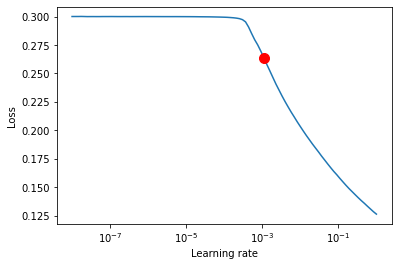

In [7]:
# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [8]:
new_lr = lr_finder.suggestion()
new_lr

0.0010964781961431851

inference = use starting LR = 1e-3 but i still stick with 1e-4 in my experiments.

In [6]:
# best recall = 0.51,epoch:1.0,eps = 0.5
# Now train this model for more epochs and track the validation results(no early stopping.)
import copy
ep = 0.5
lr  = 1e-3
new_cfg = copy.deepcopy(cfg)
cbs = ["checkpoint"]
checkpoint = {"every_n_epochs": 1,
    "monitor": "val_recall_1","save_top_k":2}

new_cfg.version += f"eps_{ep}_defaultbest"
new_cfg.cbs = cbs
new_cfg.checkpoint = checkpoint
new_cfg.eps = ep
_ = run(new_cfg)


Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Now fixing eps=0.5 and tuning over #layers

In [ ]:
# Inference:hasn't improved on recall@1. Tuning over #layers
txt_model = {'input_dim':1024,'lyrs':2,'fin_dim':1024,'act':'relu'}
img_model = {'input_dim':1024,'lyrs':2,'fin_dim':1024,'act':'relu'}
lyrs = [1,3,4]

for lyr in lyrs:
    print(f"lyr:{lyr}")
    t = copy.deepcopy(txt_model)
    i = copy.deepcopy(img_model)
    t['lyrs'] = lyr
    i['lyrl'] = i
    ep = 0.5
    new_cfg = copy.deepcopy(cfg)
    new_cfg.eps = ep
    new_cfg.version += f"lyr_{lyr}"
    new_cfg.txt_model = t
    new_cfg.img_model = i
    run(new_cfg)


0.6316236257553101

In [18]:
import pandas as pd

import os
met = '/common/home/vk405/Projects/Crossmdl/nbs/Recipe/csvlogs/'
dirs = os.listdir(met)
filt_dirs = sorted(list(filter(lambda x:'retrievallyr' in x,dirs)),key=lambda x:float(x.split('_')[1]))



In [22]:
for dir in filt_dirs:
    loc = met+dir+'/metrics.csv'
    print(f"layers:{dir.split('_')[-1]}")
    df = pd.read_csv(loc)
    fil_df = df[['val_loss','val_recall_1','epoch']].dropna()
    min_loss_id = fil_df['val_loss'].argmin()
    max_recall_id = fil_df['val_recall_1'].argmax()
    print('taking epoch with min-val-loss')
    print(f"min_val_loss:{fil_df.iloc[min_loss_id]['val_loss']},epoch:{fil_df.iloc[min_loss_id]['epoch']},recall_1:{fil_df.iloc[min_loss_id]['val_recall_1']}")
    print('taking epoch with max-recall-1')

    print(f"min_val_loss:{fil_df.iloc[max_recall_id]['val_loss']},epoch:{fil_df.iloc[max_recall_id]['epoch']},recall_1:{fil_df.iloc[max_recall_id]['val_recall_1']}")
    



layers:1
taking epoch with min-val-loss
min_val_loss:0.0329307466745376,epoch:2.0,recall_1:0.5373440384864807
taking epoch with max-recall-1
min_val_loss:0.036457534879446,epoch:0.0,recall_1:0.5445466637611389
layers:3
taking epoch with min-val-loss
min_val_loss:0.0337071418762207,epoch:5.0,recall_1:0.4441097676753998
taking epoch with max-recall-1
min_val_loss:0.0338795185089111,epoch:4.0,recall_1:0.446059376001358
layers:4
taking epoch with min-val-loss
min_val_loss:0.038360733538866,epoch:9.0,recall_1:0.2205686867237091
taking epoch with max-recall-1
min_val_loss:0.038360733538866,epoch:9.0,recall_1:0.2205686867237091


In [6]:
# inference: layers:1,min_val_loss:0.036457534879446,epoch:0.0,recall_1:0.5445466637611389
# searching over embedding layers

import copy

txt_model = {'input_dim':1024,'lyrs':2,'fin_dim':1024,'act':'relu'}
img_model = {'input_dim':1024,'lyrs':2,'fin_dim':1024,'act':'relu'}
# 1024 is already there.
hidden_dim = [256,512,2048]

for hdim in hidden_dim:

    print(f"hidden_dim:{hdim}")
    t = copy.deepcopy(txt_model)
    i = copy.deepcopy(img_model)

    t['fin_dim'] = hdim
    t['lyrs'] = 1
    t['emb_dim'] = [hdim]

    i['fin_dim'] = hdim
    i['lyrs'] = 1
    i['emb_dim'] = [hdim]

    
    
    ep = 0.5
    new_cfg = copy.deepcopy(cfg)
    new_cfg.shared_emb_dim = hdim
    new_cfg.img_model = i
    new_cfg.txt_model = t
    new_cfg.eps = ep
    new_cfg.version += f"hiddim_{hdim}"

    run(new_cfg)





Global seed set to 0


hidden_dim:256


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory /common/home/vk405/Projects/Crossmdl/nbs/Recipe/csvlogs/retrievalhiddim_256 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name    | Type     | Params
-------------------------------------
0 | txt_emb | EmbModel | 262 K 
1 | img_emb | EmbModel | 262 K 
2 | shared  | Linear   | 65.8 K
-------------------------------------
590 K     Trainable params
0         Non-trainable params
590 K     Total params
2.362     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 0


Epoch 6: 100%|██████████| 581/581 [00:54<00:00, 10.58it/s, loss=0.0106, v_num=_256] 

Global seed set to 0



hidden_dim:512


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory /common/home/vk405/Projects/Crossmdl/nbs/Recipe/csvlogs/retrievalhiddim_512 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name    | Type     | Params
-------------------------------------
0 | txt_emb | EmbModel | 524 K 
1 | img_emb | EmbModel | 524 K 
2 | shared  | Linear   | 262 K 
-------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.249     Total estimated model params size (MB)


Global seed set to 0


Epoch 3: 100%|██████████| 581/581 [00:57<00:00, 10.03it/s, loss=0.0123, v_num=_512]

Global seed set to 0



hidden_dim:2048


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/loggers/csv_logs.py:57: UserWarning: Experiment logs directory /common/home/vk405/Projects/Crossmdl/nbs/Recipe/csvlogs/retrievalhiddim_2048 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(

  | Name    | Type     | Params
-------------------------------------
0 | txt_emb | EmbModel | 2.1 M 
1 | img_emb | EmbModel | 2.1 M 
2 | shared  | Linear   | 4.2 M 
-------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.579    Total estimated model params size (MB)


Global seed set to 0


Epoch 2: 100%|██████████| 581/581 [01:05<00:00,  8.87it/s, loss=0.0119, v_num=2048]


Best Recall @1 is with layer=1 and hid_dim = 1024 with 0.54. We can use this model to check on the results in test data.

In [11]:
# Now training on typical cca loss (squared error),just add a  flag `use_mse`

# Inference: Not good at all.

cfg = Namespace(
    seed = 0,
    version = 'retrievalMSElyr_1',
    use_mse = True,
    use_cpu = True,
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/Recipe/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/Recipe/",
    mode = 'train',
    txt_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    img_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    shared_emb_dim = 1024,
    txt_emb_type = 'total',
    lr = 1e-4,
    eps = 0.5,
    loggers = ["csv"],
    cbs = ["checkpoint","early_stop"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 10},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_recall_1"},
    early_stop = {"monitor":"val_recall_1","patience":2,"mode":'max'},
    batch_size=512,
    val_batch_size = 2000


)

run(cfg)

Global seed set to 0


In [14]:
# Now just for comparision run on different embeddings - instructions,ingredients,title

# with txt_emb_type = 'instructions'
cfg = Namespace(
    seed = 0,
    version = 'retrievalINSlyr_1',
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/Recipe/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/Recipe/",
    mode = 'train',
    txt_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    img_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    shared_emb_dim = 1024,
    txt_emb_type = 'instructions',
    lr = 1e-4,
    eps = 0.5,
    loggers = ["csv"],
    cbs = ["checkpoint","early_stop"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 10},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_recall_1"},
    early_stop = {"monitor":"val_recall_1","patience":2,"mode":'max'},
    batch_size=512,
    val_batch_size = 2000


)

run(cfg)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type     | Params
-------------------------------------
0 | txt_emb | EmbModel | 1.0 M 
1 | img_emb | EmbModel | 1.0 M 
2 | shared  | Linear   | 1.0 M 
-------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.595    Total estimated model params size (MB)


Global seed set to 0


Epoch 2: 100%|██████████| 581/581 [02:10<00:00,  4.44it/s, loss=0.0302, v_num=yr_1]


In [15]:
# with txt_emb_type = 'ingredients'
cfg = Namespace(
    seed = 0,
    version = 'retrievalINGlyr_1',
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/Recipe/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/Recipe/",
    mode = 'train',
    txt_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    img_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    shared_emb_dim = 1024,
    txt_emb_type = 'ingredients',
    lr = 1e-4,
    eps = 0.5,
    loggers = ["csv"],
    cbs = ["checkpoint","early_stop"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 10},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_recall_1"},
    early_stop = {"monitor":"val_recall_1","patience":2,"mode":'max'},
    batch_size=512,
    val_batch_size = 2000


)

run(cfg)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type     | Params
-------------------------------------
0 | txt_emb | EmbModel | 1.0 M 
1 | img_emb | EmbModel | 1.0 M 
2 | shared  | Linear   | 1.0 M 
-------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.595    Total estimated model params size (MB)


Global seed set to 0


Epoch 2: 100%|██████████| 581/581 [02:44<00:00,  3.54it/s, loss=0.0299, v_num=yr_1]


In [22]:
# with txt_emb_type = 'ingredients'
cfg = Namespace(
    seed = 0,
    version = 'retrievalTITlyr_1',
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/Recipe/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/Recipe/",
    mode = 'train',
    txt_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    img_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    shared_emb_dim = 1024,
    txt_emb_type = 'title',
    lr = 1e-4,
    eps = 0.5,
    loggers = ["csv"],
    cbs = ["checkpoint","early_stop"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 10},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_recall_1"},
    early_stop = {"monitor":"val_recall_1","patience":2,"mode":'max'},
    batch_size=512,
    val_batch_size = 2000


)

run(cfg)

Global seed set to 0
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name    | Type     | Params
-------------------------------------
0 | txt_emb | EmbModel | 1.0 M 
1 | img_emb | EmbModel | 1.0 M 
2 | shared  | Linear   | 1.0 M 
-------------------------------------
3.1 M     Trainable params
0         Non-trainable params
3.1 M     Total params
12.595    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Global seed set to 0


Epoch 2: 100%|██████████| 581/581 [02:47<00:00,  3.47it/s, loss=0.0595, v_num=yr_1]
